# DAT210x - Programming with Python for DS

## Module5- Lab4

In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from sklearn import preprocessing
from sklearn.decomposition import PCA

# You might need to import more modules here..
# .. your code here ..

matplotlib.style.use('ggplot') # Look Pretty
c = ['red', 'green', 'blue', 'orange', 'yellow', 'brown']

You can experiment with these parameters:

In [2]:
PLOT_TYPE_TEXT = False    # If you'd like to see indices
PLOT_VECTORS = True       # If you'd like to see your original features in P.C.-Space

### Some Convenience Functions

In [3]:
def drawVectors(transformed_features, components_, columns, plt):
    num_columns = len(columns)

    # This function will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    ## Visualize projections

    # Sort each column by its length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Projected Features by importance:\n", important_features)

    ax = plt.axes()

    for i in range(num_columns):
        # Use an arrow to project each original feature as a
        # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75, zorder=600000)
        plt.text(xvector[i]*1.2, yvector[i]*1.2, list(columns)[i], color='b', alpha=0.75, zorder=600000)
        
    return ax

In [4]:
def doPCA(data, dimensions=2):
    model = PCA(n_components=dimensions, svd_solver='randomized', random_state=7)
    model.fit(data)
    return model

In [5]:
from sklearn.cluster import KMeans
def doKMeans(data, num_clusters=0):
    # TODO: Do the KMeans clustering here, passing in the # of clusters parameter
    # and fit it against your data. Then, return a tuple containing the cluster
    # centers and the labels.
    #
    # Hint: Just like with doPCA above, you will have to create a variable called
    # `model`, which will be a SKLearn K-Means model for this to work.
    model = KMeans(n_clusters=num_clusters)
    model.fit(data)
    
    # .. your code here ..
    return model.cluster_centers_, model.labels_

Load up the dataset. It may or may not have nans in it. Make sure you catch them and destroy them, by setting them to `0`. This is valid for this dataset, since if the value is missing, you can assume no money was spent on it.

In [6]:
# .. your code here ..
df1 = pd.read_csv('Datasets/Wholesale customers data.csv')

As instructed, get rid of the `Channel` and `Region` columns, since you'll be investigating as if this were a single location wholesaler, rather than a national / international one. Leaving these fields in here would cause KMeans to examine and give weight to them:

In [7]:
# .. your code here ..
df1.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

Before unitizing / standardizing / normalizing your data in preparation for K-Means, it's a good idea to get a quick peek at it. You can do this using the `.describe()` method, or even by using the built-in pandas `df.plot.hist()`:

In [8]:
# .. your code here ..
df1.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Having checked out your data, you may have noticed there's a pretty big gap between the top customers in each feature category and the rest. Some feature scaling algorithms won't get rid of outliers for you, so it's a good idea to handle that manually---particularly if your goal is NOT to determine the top customers. 

After all, you can do that with a simple Pandas `.sort_values()` and not a machine learning clustering algorithm. From a business perspective, you're probably more interested in clustering your +/- 2 standard deviation customers, rather than the top and bottom customers.

Remove top 5 and bottom 5 samples for each column:

In [9]:
df = df1
drop = {}
for col in df.columns:
    # Bottom 5
    sort = df.sort_values(by=col, ascending=True)
    if len(sort) > 5: sort=sort[:5]
    for index in sort.index: drop[index] = True # Just store the index once

    # Top 5
    sort = df.sort_values(by=col, ascending=False)
    if len(sort) > 5: sort=sort[:5]
    for index in sort.index: drop[index] = True # Just store the index once

Drop rows by index. We do this all at once in case there is a collision. This way, we don't end up dropping more rows than we have to, if there is a single row that satisfies the drop for multiple columns. Since there are 6 rows, if we end up dropping < 5*6*2 = 60 rows, that means there indeed were collisions:

In [10]:
print("Dropping {0} Outliers...".format(len(drop)))
df.drop(inplace=True, labels=drop.keys(), axis=0)
df.describe()

Dropping 59 Outliers...


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,1.322835,2.538058,11048.149606,5114.732283,7032.472441,2635.818898,2519.559055,1274.514436
std,0.468175,0.772382,9819.036393,5021.269258,6814.829465,3001.432034,3501.138150,1221.140467
min,1.000000,1.000000,37.000000,258.000000,314.000000,47.000000,10.000000,11.000000
25%,1.000000,2.000000,3366.000000,1511.000000,2157.000000,744.000000,275.000000,406.000000
50%,1.000000,3.000000,8590.000000,3610.000000,4583.000000,1492.000000,811.000000,925.000000
75%,2.000000,3.000000,16165.000000,6817.000000,9794.000000,3347.000000,3837.000000,1755.000000
max,2.000000,3.000000,53205.000000,29892.000000,39694.000000,17866.000000,19410.000000,7844.000000


### What are you interested in?

Depending on what you're interested in, you might take a different approach to normalizing/standardizing your data.
 
You should note that all columns left in the dataset are of the same unit. You might ask yourself, do I even need to normalize / standardize the data? The answer depends on what you're trying to accomplish. For instance, although all the units are the same (generic money unit), the price per item in your store isn't. There may be some cheap items and some expensive one. If your goal is to find out what items people tend to buy together but you didn't  "unitize" properly before running kMeans, the contribution of the lesser priced item would be dwarfed by the more expensive item. This is an issue of scale.

For a great overview on a few of the normalization methods supported in SKLearn, please check out: https://stackoverflow.com/questions/30918781/right-function-for-normalizing-input-of-sklearn-svm

Suffice to say, at the end of the day, you're going to have to know what question you want answered and what data you have available in order to select the best method for your purpose. Luckily, SKLearn's interfaces are easy to switch out so in the mean time, you can experiment with all of them and see how they alter your results.

5-sec summary before you dive deeper online:

### Normalization

Let's say your user spend a LOT. Normalization divides each item by the average overall amount of spending. Stated differently, your new feature is = the contribution of overall spending going into that particular item: \$spent on feature / \$overall spent by sample.

### MinMax

What % in the overall range of $spent by all users on THIS particular feature is the current sample's feature at? When you're dealing with all the same units, this will produce a near face-value amount. Be careful though: if you have even a single outlier, it can cause all your data to get squashed up in lower percentages.

Imagine your buyers usually spend \$100 on wholesale milk, but today only spent \$20. This is the relationship you're trying to capture with MinMax. NOTE: MinMax doesn't standardize (std. dev.); it only normalizes / unitizes your feature, in the mathematical sense. MinMax can be used as an alternative to zero mean, unit variance scaling. [(sampleFeatureValue-min) / (max-min)] * (max-min) + min Where min and max are for the overall feature values for all samples.

### Back to The Assignment

Un-comment just ***ONE*** of lines at a time and see how alters your results. Pay attention to the direction of the arrows, as well as their LENGTHS:

In [11]:
df.drop(['Channel', 'Region'], inplace=True, axis=1)
#T = preprocessing.StandardScaler().fit_transform(df)
T = preprocessing.MinMaxScaler().fit_transform(df)
#T = preprocessing.MaxAbsScaler().fit_transform(df)
#T = preprocessing.Normalizer().fit_transform(df)
#T = df # No Change

Sometimes people perform PCA before doing KMeans, so that KMeans only operates on the most meaningful features. In our case, there are so few features that doing PCA ahead of time isn't really necessary, and you can do KMeans in feature space. But keep in mind you have the option to transform your data to bring down its dimensionality. If you take that route, then your Clusters will already be in PCA-transformed feature space, and you won't have to project them again for visualization.

In [12]:
# Do KMeans

n_clusters = 3
centroids, labels = doKMeans(T, n_clusters)

Print out your centroids. They're currently in feature-space, which is good. Print them out before you transform them into PCA space for viewing

In [13]:
# .. your code here ..
for i in range(len(centroids)):
    print('Centeroid is ', centroids[i])
    
centroids

Centeroid is  [ 0.15242029  0.09121694  0.09357992  0.1077249   0.05898875  0.11090549]
Centeroid is  [ 0.09572035  0.38501581  0.44510827  0.08666949  0.41762016  0.19790231]
Centeroid is  [ 0.45241163  0.15152801  0.12071483  0.29738388  0.04942133  0.25976333]


array([[ 0.15242029,  0.09121694,  0.09357992,  0.1077249 ,  0.05898875,
         0.11090549],
       [ 0.09572035,  0.38501581,  0.44510827,  0.08666949,  0.41762016,
         0.19790231],
       [ 0.45241163,  0.15152801,  0.12071483,  0.29738388,  0.04942133,
         0.25976333]])

Now that we've clustered our KMeans, let's do PCA, using it as a tool to visualize the results. Project the centroids as well as the samples into the new 2D feature space for visualization purposes:

In [14]:
display_pca = doPCA(T)
T = display_pca.transform(T)
CC = display_pca.transform(centroids)

Visualize all the samples. Give them the color of their cluster label

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
if PLOT_TYPE_TEXT:
    # Plot the index of the sample, so you can further investigate it in your dset
    for i in range(len(T)): ax.text(T[i,0], T[i,1], df.index[i], color=c[labels[i]], alpha=0.75, zorder=600000)
    ax.set_xlim(min(T[:,0])*1.2, max(T[:,0])*1.2)
    ax.set_ylim(min(T[:,1])*1.2, max(T[:,1])*1.2)
else:
    # Plot a regular scatter plot
    sample_colors = [ c[labels[i]] for i in range(len(T)) ]
    ax.scatter(T[:, 0], T[:, 1], c=sample_colors, marker='o', alpha=0.2)

Plot the Centroids as X's, and label them

In [16]:
ax.scatter(CC[:, 0], CC[:, 1], marker='x', s=169, linewidths=3, zorder=1000, c=c)
for i in range(len(centroids)):
    ax.text(CC[i, 0], CC[i, 1], str(i), zorder=500010, fontsize=18, color=c[i])

In [17]:
# Display feature vectors for investigation:
if PLOT_VECTORS:
    drawVectors(T, display_pca.components_, df.columns, plt)

Projected Features by importance:
 [(0.7976907361758674, 'Detergents_Paper'), (0.7752846096225917, 'Grocery'), (0.7057522444496211, 'Milk'), (0.5637742095744286, 'Fresh'), (0.40648844849796634, 'Frozen'), (0.38436547228211126, 'Delicassen')]


In [18]:
# Add the cluster label back into the dataframe and display it:
df['label'] = pd.Series(labels, index=df.index)
df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,label
1,7057,9810,9568,1762,3293,1776,0
2,6353,8808,7684,2405,3516,7844,2
3,13265,1196,4221,6404,507,1788,2
4,22615,5410,7198,3915,1777,5185,2
5,9413,8259,5126,666,1795,1451,0
6,12126,3199,6975,480,3140,545,0
7,7579,4956,9426,1669,3321,2566,0
8,5963,3648,6192,425,1716,750,0
9,6006,11093,18881,1159,7425,2098,1
10,3366,5403,12974,4400,5977,1744,1


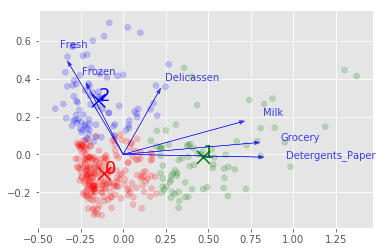

In [19]:
plt.show()

In [20]:
display_pca.components_

array([[-0.22718043,  0.49926603,  0.56314616, -0.14819314,  0.58111605,
         0.14943831],
       [ 0.67612889,  0.24322742,  0.08746298,  0.50661536, -0.02054024,
         0.46793093]])